In [1]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Crop Images


In [2]:
def crop_images(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if cnts:
        # Find the largest contour
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Add contour and extreme points to the image
        img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)

        # Apply crop
        ADD_PIXELS = 0
        new_image = image[
            extTop[1] - ADD_PIXELS : extBot[1] + ADD_PIXELS,
            extLeft[0] - ADD_PIXELS : extRight[0] + ADD_PIXELS,
        ].copy()

        return new_image
    else:
        return None

In [3]:
def crop_and_save_images(input_directory, output_directory):
    plot_shown = False  # Flag to ensure plot is shown only once

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Crop the image
                cropped_image = crop_images(image)

                if cropped_image is not None:
                    # Save the cropped image
                    class_name = os.path.basename(os.path.dirname(image_path))
                    class_directory = os.path.join(output_directory, class_name)
                    os.makedirs(class_directory, exist_ok=True)
                    new_image_path = os.path.join(class_directory, file)
                    cv2.imwrite(new_image_path, cropped_image)

                    if not plot_shown:
                        # Plot the sequential steps only if not shown before
                        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        axs[0].set_title("Original Image")
                        axs[0].axis("off")

                        axs[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                        axs[1].set_title("Cropped Image")
                        axs[1].axis("off")

                        plt.tight_layout()
                        plt.show()
                        plot_shown = True

## Augmented Data


In [4]:
def augment_images(input_directory, output_directory, num_images=5):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        rescale=1.0 / 255,
        shear_range=0.05,
        brightness_range=[0.1, 1.5],
        horizontal_flip=True,
        vertical_flip=True,
    )

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image.reshape((1,) + image.shape)
                save_prefix = file.split(".")[0] + "_aug"

                class_name = os.path.basename(os.path.dirname(image_path))
                data_split = os.path.basename(
                    os.path.dirname(os.path.dirname(image_path))
                )

                class_directory = os.path.join(output_directory, data_split, class_name)
                os.makedirs(class_directory, exist_ok=True)

                i = 0
                for batch in datagen.flow(
                    image,
                    batch_size=1,
                    save_to_dir=class_directory,
                    save_prefix=save_prefix,
                    save_format="jpg",
                ):
                    i += 1
                    if i >= num_images:
                        break

## Crop Data Without Augmentation


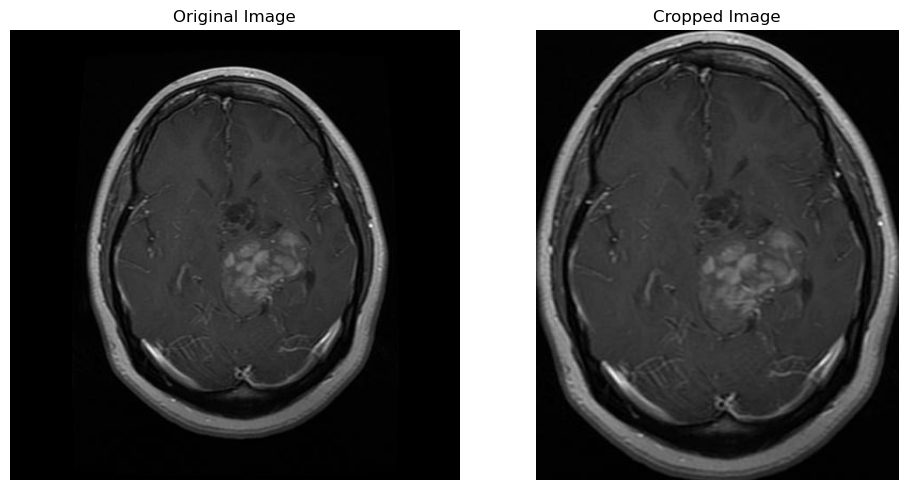

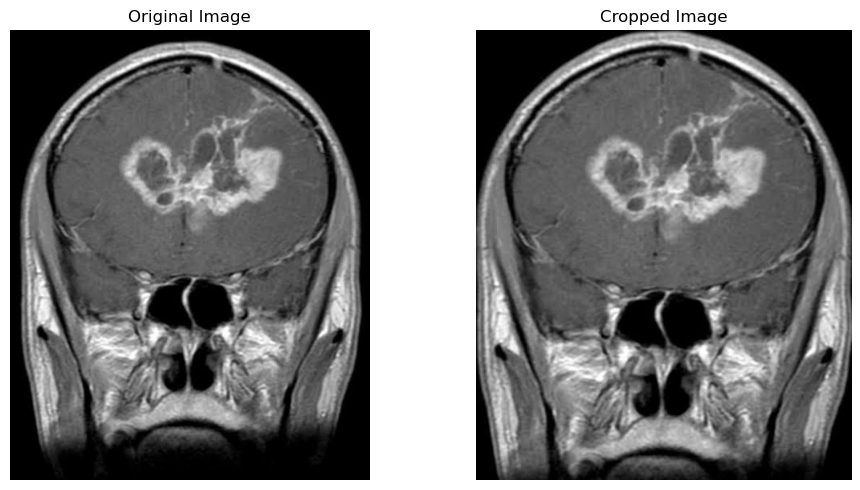

In [5]:
cropped_train = "Brain Tumor/Training"
cropped_test = "Brain Tumor/Testing"

cropped_train_directory = "./Images_Cropped_No_Augmentation/cropped_training/"
os.makedirs(cropped_train_directory, exist_ok=True)
crop_and_save_images(cropped_train, cropped_train_directory)

cropped_test_directory = "./Images_Cropped_No_Augmentation/cropped_testing/"
os.makedirs(cropped_test_directory, exist_ok=True)
crop_and_save_images(cropped_test, cropped_test_directory)

## Augmentaion


In [6]:
augmented_directory = "./augmented_data/"
train_directory = "./Brain Tumor/Training"
test_directory = "./Brain Tumor/Testing"
augment_images(train_directory, augmented_directory)
augment_images(test_directory, augmented_directory)

## Cropping Data With Augmentaion


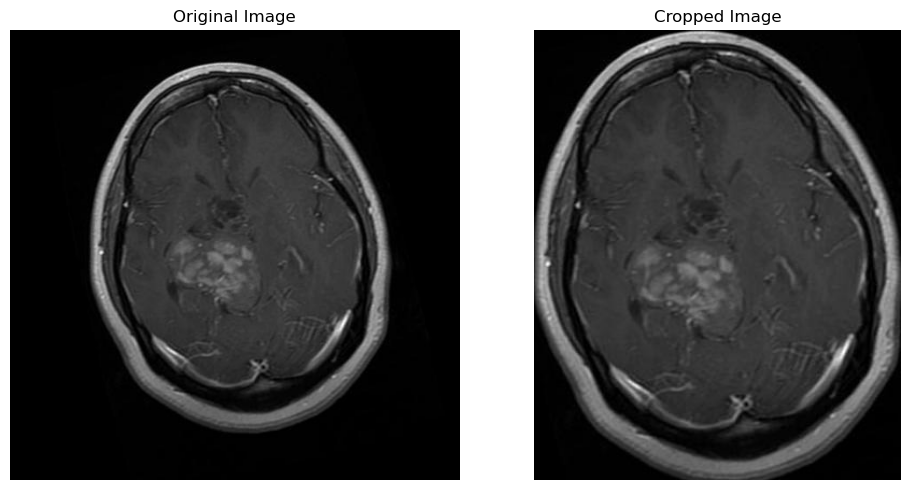

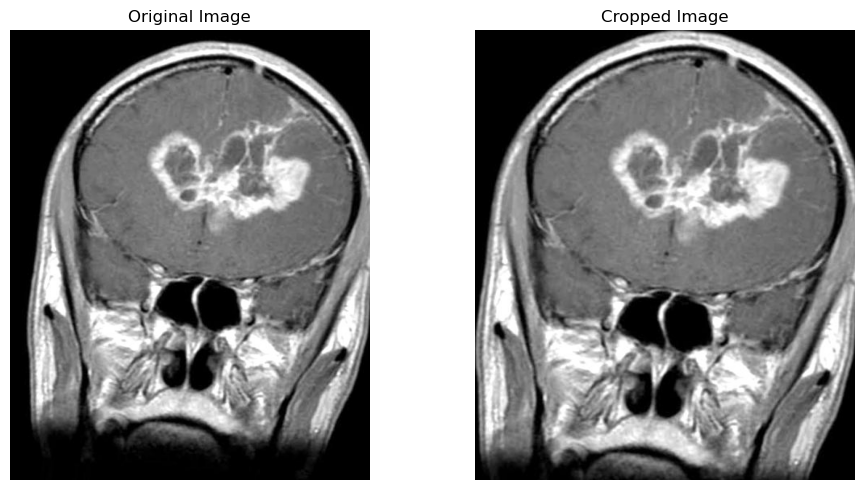

In [7]:
cropped_train = "./augmented_data/Training"
cropped_test = "./augmented_data/Testing"

cropped_train_directory = "./Images_Cropped_With_Augmentation/cropped_training/"
os.makedirs(cropped_train_directory, exist_ok=True)
crop_and_save_images(cropped_train, cropped_train_directory)

cropped_test_directory = "./Images_Cropped_With_Augmentation/cropped_testing/"
os.makedirs(cropped_test_directory, exist_ok=True)
crop_and_save_images(cropped_test, cropped_test_directory)